Step 1: Importing the Relevant Libraries


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from  sklearn import preprocessing
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
import tensorflow as tf

Step 2: Data 

In [3]:
train = pd.read_csv("TRAIN.csv")
test = pd.read_csv("TEST_FINAL.csv")

In [4]:
train.shape,test.shape

((188340, 10), (22265, 8))

In [5]:
#ratio of null values
train.isnull().sum()/train.shape[0] *100

ID               0.0
Store_id         0.0
Store_Type       0.0
Location_Type    0.0
Region_Code      0.0
Date             0.0
Holiday          0.0
Discount         0.0
#Order           0.0
Sales            0.0
dtype: float64

In [6]:
#ratio of null values
test.isnull().sum()/test.shape[0] *100

ID               0.0
Store_id         0.0
Store_Type       0.0
Location_Type    0.0
Region_Code      0.0
Date             0.0
Holiday          0.0
Discount         0.0
dtype: float64

In [10]:
train.describe(include= 'all')

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
count,188340,188340.000000,188340,188340,188340,188340,188340.000000,188340,188340.000000,188340.000000
unique,188340,NaN,4,5,4,516,NaN,2,NaN,NaN
top,T1088315,NaN,S1,L1,R1,2019-01-31,NaN,No,NaN,NaN
freq,1,NaN,88752,85140,63984,365,NaN,104051,NaN,NaN
mean,NaN,183.000000,NaN,NaN,NaN,NaN,0.131783,NaN,68.205692,42784.327982
std,NaN,105.366308,NaN,NaN,NaN,NaN,0.338256,NaN,30.467415,18456.708302
min,NaN,1.000000,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000
25%,NaN,92.000000,NaN,NaN,NaN,NaN,0.000000,NaN,48.000000,30426.000000
50%,NaN,183.000000,NaN,NaN,NaN,NaN,0.000000,NaN,63.000000,39678.000000
75%,NaN,274.000000,NaN,NaN,NaN,NaN,0.000000,NaN,82.000000,51909.000000


Data Cleaning

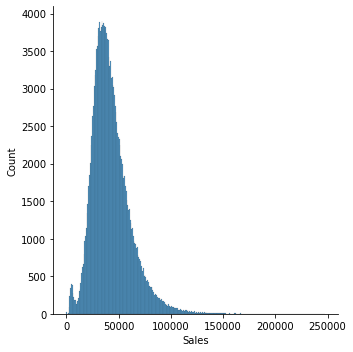

In [11]:
sns.displot(train['Sales'])

In [12]:
# Obviously there are some outliers present 

# Without diving too deep into the topic, we can deal with the problem easily by removing 0.5%, or 1% of the problematic samples
# Here, the outliers are situated around the higher prices (right side of the graph)
# Logic should also be applied
# This is a dataset about used cars, therefore one can imagine how $300,000 is an excessive price

# Outliers are a great issue for OLS, thus we must deal with them in some way
# It may be a useful exercise to try training a model without removing the outliers

# Let's declare a variable that will be equal to the 99th percentile of the 'Price' variable
q = train['Sales'].quantile(0.99)
# Then we can create a new df, with the condition that all prices must be below the 99 percentile of 'Price'
data_1 = train[train['Sales']<q]
# In this way we have essentially removed the top 1% of the data about 'Price'
data_1.describe(include='all')

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
count,186455,186455.000000,186455,186455,186455,186455,186455.000000,186455,186455.000000,186455.000000
unique,186455,NaN,4,5,4,516,NaN,2,NaN,NaN
top,T1088315,NaN,S1,L1,R1,2019-01-31,NaN,No,NaN,NaN
freq,1,NaN,88706,85024,62740,365,NaN,103602,NaN,NaN
mean,NaN,182.867668,NaN,NaN,NaN,NaN,0.132375,NaN,67.011048,42017.404721
std,NaN,105.451277,NaN,NaN,NaN,NaN,0.338899,NaN,27.969388,16802.819315
min,NaN,1.000000,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000
25%,NaN,91.000000,NaN,NaN,NaN,NaN,0.000000,NaN,48.000000,30330.000000
50%,NaN,183.000000,NaN,NaN,NaN,NaN,0.000000,NaN,62.000000,39477.000000
75%,NaN,274.000000,NaN,NaN,NaN,NaN,0.000000,NaN,81.000000,51415.860000


In [13]:
data_cleaned = data_1.reset_index(drop=True)

In [15]:
data_cleaned

,ID,Store_id,Store_Type,Location_Type,Region_Code,Date,Holiday,Discount,#Order,Sales
0,T1000001,1,S1,L3,R1,2018-01-01,1,Yes,9,7011.84
1,T1000002,253,S4,L2,R1,2018-01-01,1,Yes,60,51789.12
2,T1000003,252,S3,L2,R1,2018-01-01,1,Yes,42,36868.20
3,T1000004,251,S2,L3,R1,2018-01-01,1,Yes,23,19715.16
4,T1000005,250,S2,L3,R4,2018-01-01,1,Yes,62,45614.52
...,...,...,...,...,...,...,...,...,...,...
186450,T1188336,149,S2,L3,R2,2019-05-31,1,Yes,51,37272.00
186451,T1188337,153,S4,L2,R1,2019-05-31,1,No,90,54572.64
186452,T1188338,154,S1,L3,R2,2019-05-31,1,No,56,31624.56
186453,T1188339,155,S3,L1,R2,2019-05-31,1,Yes,70,49162.41


Dealing with categorical variables

In [16]:
traind = data_cleaned

In [19]:
testd = test

In [17]:
le = LabelEncoder()
var_mod = traind.select_dtypes(include='object').columns
for i in var_mod:
    traind[i] = le.fit_transform(traind[i].astype(str))

In [20]:
le = LabelEncoder()
var_mod = testd.select_dtypes(include='object').columns
for i in var_mod:
    testd[i] = le.fit_transform(testd[i].astype(str))

In [22]:
# The target(s) 
targets = traind['Sales']

# The inputs 
inputs = traind.drop(['#Order','Sales'],axis=1)

Scaling

In [23]:
scaled_inputs_train = preprocessing.scale(inputs)
scaled_inputs_test =  preprocessing.scale(testd)

In [27]:
samples_count = scaled_inputs_train.shape[0]

# Count the samples in each subset, assuming we want 80-10-10 distribution of training, validation, and test.
# Naturally, the numbers are integers.
train_samples_count = int(0.8 * samples_count)
validation_samples_count = int(0.2 * samples_count)



# Create variables that record the inputs and targets for training
# In our shuffled dataset, they are the first "train_samples_count" observations
train_inputs = scaled_inputs_train[:train_samples_count]
train_targets = targets[:train_samples_count]

# Create variables that record the inputs and targets for validation.
# They are the next "validation_samples_count" observations, folllowing the "train_samples_count" we already assigned
validation_inputs = scaled_inputs_train[train_samples_count:train_samples_count+validation_samples_count]
validation_targets = targets[train_samples_count:train_samples_count+validation_samples_count]

In [29]:
scaled_inputs_test.shape

(22265, 8)

MOdel

In [30]:
input_size = 8
output_size = 1
# Use same hidden layer size for both hidden layers. Not a necessity.
hidden_layer_size = 50
    
# define how the model will look like
model = tf.keras.Sequential([
    
    
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 1st hidden layer
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 2nd hidden layer
    
    tf.keras.layers.Dense(output_size, activation= 'linear') # output layer
])

In [31]:
model.compile(optimizer='adam', loss='mse', metrics=['mse','mae'])

Training the model

In [32]:
batch_size = 100

# set a maximum number of training epochs
max_epochs = 100

# set an early stopping mechanism
# let's set patience=2, to be a bit tolerant against random validation loss increases
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2)

# fit the model
# note that this time the train, validation and test data are not iterable
model.fit(train_inputs, # train inputs
          train_targets, # train targets
          batch_size=batch_size, # batch size
          epochs=max_epochs, # epochs that we will train for (assuming early stopping doesn't kick in)
          # callbacks are functions called by a task when a task is completed
          # task here is to check if val_loss is increasing
          callbacks=[early_stopping], # early stopping
          validation_data=(validation_inputs, validation_targets), # validation data
          verbose = 2 # making sure we get enough information about the training process
          ) 

Epoch 1/100
1492/1492 - 3s - loss: 1333661312.0000 - mse: 1333661312.0000 - mae: 31889.2246 - val_loss: 1371041792.0000 - val_mse: 1371041792.0000 - val_mae: 34067.5000
Epoch 2/100
1492/1492 - 2s - loss: 274489632.0000 - mse: 274489600.0000 - mae: 12673.4502 - val_loss: 223278096.0000 - val_mse: 223278096.0000 - val_mae: 11098.3350
Epoch 3/100
1492/1492 - 2s - loss: 160534784.0000 - mse: 160534784.0000 - mae: 9560.4912 - val_loss: 174983744.0000 - val_mse: 174983728.0000 - val_mae: 9926.9033
Epoch 4/100
1492/1492 - 2s - loss: 152008096.0000 - mse: 152008096.0000 - mae: 9270.6719 - val_loss: 169701168.0000 - val_mse: 169701168.0000 - val_mae: 9780.8184
Epoch 5/100
1492/1492 - 2s - loss: 147444400.0000 - mse: 147444400.0000 - mae: 9105.1035 - val_loss: 165996112.0000 - val_mse: 165996112.0000 - val_mae: 9657.9805
Epoch 6/100
1492/1492 - 2s - loss: 143842448.0000 - mse: 143842448.0000 - mae: 8970.5508 - val_loss: 161595664.0000 - val_mse: 161595664.0000 - val_mae: 9572.1748
Epoch 7/100
14

model through simple linear regression

Testing

In [37]:
submission_now = pd.read_csv('TEST_FINAL.csv')
final_predictions = model.predict(scaled_inputs_test)
submission_now['Sales'] = final_predictions


In [39]:
#only positive predictions for the target variable
submission_now['Sales'] = submission_now['Sales'].apply(lambda x: 0 if x<0 else x)
submission_now.to_csv('my_submission.csv', index=False)